<a href="https://colab.research.google.com/github/shauryanegi/tensorflow-deep-learning/blob/gh-pages/transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with Tensorflow part 2: Fine tuning

In the previous section, we saw how we could leverage feature extraction transfer learning to get far better results on our Food Vision project than building our own models (even with less data).

Now we're going to cover another type of transfer learning: fine-tuning.

In fine-tuning transfer learning the pre-trained model weights from another model are unfrozen and tweaked during to better suit your own data.

For feature extraction transfer learning, you may only train the top 1-3 layers of a pre-trained model with your own data, in fine-tuning transfer learning, you might train 1-3+ layers of a pre-trained model (where the '+' indicates that many or all of the layers could be trained).

In [59]:
# Check if we are using a GPU
!nvidia-smi

Sun Aug 15 13:09:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    72W / 149W |   4346MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous functions, we wrote some helper functions, we could rewrite them all, however, it is tedious.

So, it is a good idea to put functions, you want to use again in a script you can download and import into your notebooks (or elsewhere).

We've done this for some functions we used previously.
https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [60]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-08-15 13:09:57--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-08-15 13:09:58 (72.0 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [61]:
# Import helper functions we're going to use in this notebook.
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## 10 Food Classes: Working with less data
We saw in the previous notebook that we could get great results with only 10% of the training data using transfer learning with TensorFlow Hub.

In this notebook, we're going to continue to work with smaller subsets of the data, except this time we'll have a look at how we can use the in-built pretrained models within the tf.keras.applications module as well as how to fine-tune them to our own custom dataset.

We'll also practice using a new but similar dataloader function to what we've used before, image_dataset_from_directory() which is part of the tf.keras.preprocessing module.

Finally, we'll also be practicing using the Keras Functional API for building deep learning models. The Functional API is a more flexible way to create models than the tf.keras.Sequential API.

We'll explore each of these in more detail as we go.

Let's start by downloading some data.

In [62]:
# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 

unzip_data("10_food_classes_10_percent.zip")

--2021-08-15 13:09:58--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 74.125.204.128, 64.233.189.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   179MB/s    in 0.9s    

2021-08-15 13:09:59 (179 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]




The dataset we're downloading is the 10 food classes dataset (from Food 101) with 10% of the training images we used in the previous notebook.

🔑 Note: You can see how this dataset was created in the image data modification notebook.

In [63]:
# Walk through 10 percent data directory and list number of files
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

In [64]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [65]:
import tensorflow as tf
IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode = 'categorical',
                                                                            batch_size = BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                                image_size = IMG_SIZE,
                                                                label_mode  = 'categorical',
                                                                batch_size = BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [66]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [67]:
# Check out class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [68]:
#See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images,labels)

tf.Tensor(
[[[[  5.642857    0.          3.642857 ]
   [  5.642857    0.          3.642857 ]
   [  5.642857    0.          3.642857 ]
   ...
   [  8.933685    2.9336853   4.9336853]
   [ 10.          4.          6.       ]
   [  8.000005    2.0000043   4.0000043]]

  [[  6.9285717   0.9285717   4.9285717]
   [  6.9285717   0.9285717   4.9285717]
   [  6.9285717   0.9285717   4.9285717]
   ...
   [  9.229601    3.2296011   5.229601 ]
   [ 10.071428    4.0714283   6.0714283]
   [  8.357147    2.3571472   4.357147 ]]

  [[  7.          1.          5.       ]
   [  7.          1.          5.       ]
   [  7.          1.          5.       ]
   ...
   [  7.4285803   1.4285803   3.4285803]
   [  8.214286    2.2142859   4.214286 ]
   [  6.4336786   0.4336788   2.4336789]]

  ...

  [[ 24.85712    10.857121    7.857121 ]
   [ 22.214264   11.214264    7.214264 ]
   [ 22.214264   11.214264    7.214264 ]
   ...
   [ 33.92874    26.83691    17.311354 ]
   [ 36.42874    29.000214   19.643005 ]
   [ 

# Model 0 : Build a transfer learning model using Keras Functional API

The Squential API is straight-forward, it runs our layers in Sequential order.
But the functional API gives us more flexibility with our models.

In [69]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top= False)

# 2. Freeze the base model (so the underlying pre-trained patterns are not updated during training)
base_model.trainable = False

# 3. Create inputs into a model
inputs = tf.keras.layers.Input(shape = (224,224,3), name = "input_layer")

# 4. If using a model like ResNet50V2 you will need to normalize inputs
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

#5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model:{x.shape}")

#6. Average pool the outputs of the base model (aggregate all important information)
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation = "softmax", name = "output_layer")(x)

#8. Combine the inputs and the outputs in a model
model_0 = tf.keras.Model(inputs,outputs)

#9. Compile a model
model_0.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
                metrics = ['accuracy'])

# 10. Fit the model and save its history
history_10_percent = model_0.fit(train_data_10_percent,
            epochs = 5,
            steps_per_epoch = len(train_data_10_percent),
            validation_data = test_data,
            validation_steps = int(0.25 * len(test_data)),
            callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                     experiment_name = "10_percent")])

Shape after passing inputs through base model:(None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent/20210815-131004
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 16s 425ms/step - loss: 1.1252 - accuracy: 0.6373 - val_loss: 0.4963 - val_accuracy: 0.8339
Epoch 2/5
24/24 [==============================] - 9s 381ms/step - loss: 0.3523 - accuracy: 0.8933 - val_loss: 0.4521 - val_accuracy: 0.8372
Epoch 3/5
24/24 [==============================] - 8s 320ms/step - loss: 0.1972 - accuracy: 0.9400 - val_loss: 0.4738 - val_accuracy: 0.8388
Epoch 4/5
24/24 [==============================] - 8s 318ms/step - loss: 0.1261 - accuracy: 0.9720 - val_loss: 0.4604 - val_accuracy: 0.8569
Epoch 5/5
24/24 [==============================] - 9s 380ms/step - loss: 0.0880 - accuracy: 0.9827 - val_loss: 0.4500 - val_accuracy: 0.8553


In [70]:
# Evaluate on the full dataset
model_0.evaluate(test_data)

79/79 [==============================] - 14s 172ms/step - loss: 0.4624 - accuracy: 0.8436


[0.4623830020427704, 0.8435999751091003]

In [71]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_4
1 rescaling_3
2 normalization_3
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_d

In [72]:
# Summary of the base model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling_3 (Rescaling)         (None, None, None, 3 0           input_4[0][0]                    
__________________________________________________________________________________________________
normalization_3 (Normalization) (None, None, None, 3 7           rescaling_3[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization_3[0][0]            
_____________________________________________________________________________________

In [73]:
# How about a summary of our whole model?
model_0.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


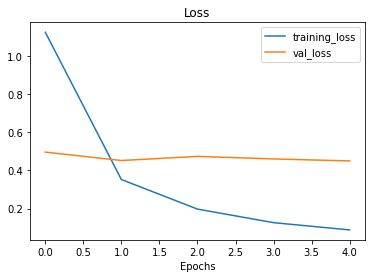

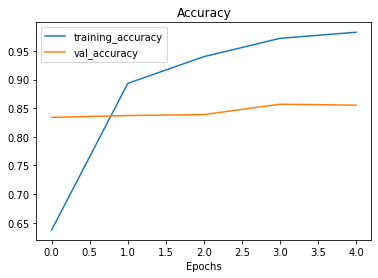

In [74]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model

The tf.keras.layers.GlobalAveragePooling2D() layer transforms a 4D tensor into a 2D tensor by averaging the values across the inner-axes.

The previous sentence is a bit of a mouthful, so let's see an example.

In [75]:
# Define input tensor shape (same number of dimensions as the output of efficientnetb0)
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shapes of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global averaged pooled input tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor: (1, 3)


In [76]:
# Let's replicate the GlobalAverage2D layer
tf.reduce_mean(input_tensor, axis = [1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

##Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

**Note** Throughout all experiments the same test dataset will be used to evaluate our model... this ensures consistency across evaluation metrics.

In [77]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

--2021-08-15 13:11:25--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 74.125.204.128, 64.233.189.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.1’

10_food_classes_1_p 100%[===================>] 127.42M  75.6MB/s    in 1.7s    

2021-08-15 13:11:27 (75.6 MB/s) - ‘10_food_classes_1_percent.zip.1’ saved [133612354/133612354]



In [78]:
# Walk through 1 percent data directory and list number of files
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'

In [79]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           batch_size=32, # default
                                                                           image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model
To add data augmentation right into the models, we can use the layers inside:

In [80]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotation, zooms, etc.
data_augmentation = tf.keras.Sequential([
                                         preprocessing.RandomFlip("horizontal"),
                                         preprocessing.RandomRotation(0.2),
                                         preprocessing.RandomZoom(0.2),
                                         preprocessing.RandomHeight(0.2),
                                         preprocessing.RandomWidth(0.2),
                                         #preprocessing.Rescale(1./255) Keep for other models. EfficentNet has rescaling built in.
                                         ], name = "data_augmentation"
                                         )

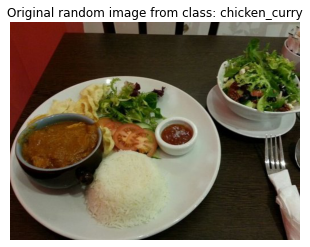

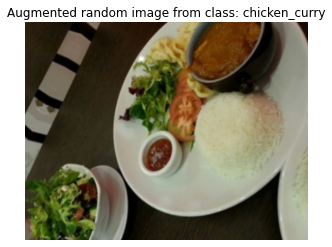

In [81]:
# View a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names) # choose a random class
target_dir = "10_food_classes_1_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

## Building Model 1: Feature Extraction Transfer Learning on 1% of the data with data augmentation

In [82]:
# Setup the input shape and base model, freezing the base model layers.
input_shape = (224,224,3)

base_model = tf.keras.applications.EfficientNetB0(include_top= False)
base_model.trainable = False

# Create the input layer
inputs = tf.keras.layers.Input(shape = input_shape, name = 'input_layer')

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base model the inputs after they are augmented and don't train it
x = base_model(x, training = False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name = 'global_average_pooling_layer')(x)

# Put a Dense layer on as the output
outputs = layers.Dense(10, activation= 'softmax', name = "output_layer")(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs,outputs)

# Compile the model
model_1.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
                metrics = ['accuracy'])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs = 5,
                                steps_per_epoch = len(train_data_1_percent),
                                validation_data = test_data,
                                validation_steps = int(0.25 * len(test_data)),
                                                       # Track model training logs
                                callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                                                                experiment_name ="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20210815-131134
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


3/3 [==============================] - 14s 4s/step - loss: 2.3086 - accuracy: 0.1857 - val_loss: 1.4967 - val_accuracy: 0.5296
Epoch 2/5
3/3 [==============================] - 5s 2s/step - loss: 0.8241 - accuracy: 0.8000 - val_loss: 1.3176 - val_accuracy: 0.5428
Epoch 3/5
3/3 [==============================] - 5s 2s/step - loss: 0.4717 - accuracy: 0.9143 - val_loss: 1.0799 - val_accuracy: 0.6447
Epoch 4/5
3/3 [==============================] - 6s 3s/step - loss: 0.2312 - accuracy: 0.9714 - val_loss: 1.0133 - val_accuracy: 0.6530
Epoch 5/5
3/3 [==============================] - 5s 2s/step - loss: 0.1472 - accuracy: 0.9714 - val_loss: 1.0101 - val_accuracy: 0.6579


In [83]:
# Evaluate on the full dataset
result_1_percent_data_aug = model_1.evaluate(test_data)

79/79 [==============================] - 14s 172ms/step - loss: 0.9984 - accuracy: 0.6568


In [84]:
# Check out model summary
model_1.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


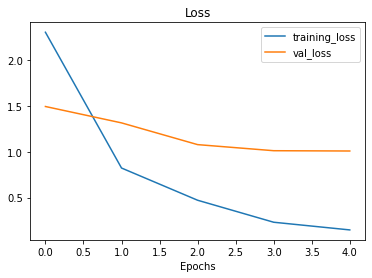

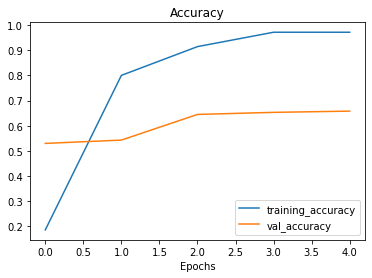

In [85]:
# How does the model go with data augmentation? 
plot_loss_curves(history_1_percent)

## Let us run Model2:

## Model 2: Feature extraction transfer learning with 10% of data and data augmentation

In [86]:
# Get 10% of the data of the 10 classes (uncomment if you haven't gotten "10_food_classes_10_percent.zip" already)
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# unzip_data("10_food_classes_10_percent.zip")

train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [87]:
# Set data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Awesome! We've got 10x more images to work with, 75 per class instead of 7 per class.

Let's build a model with data augmentation built in. We could reuse the data augmentation Sequential model we created before but we'll recreate it to practice.

In [88]:
# Create a functional model with data augmentation
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentation = keras.Sequential([
                                      preprocessing.RandomFlip("horizontal"),
                                      preprocessing.RandomHeight(0.2),
                                      preprocessing.RandomWidth(0.2),
                                      preprocessing.RandomZoom(0.2),
                                      preprocessing.RandomRotation(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet                 
], name="data_augmentation")

# Set the imput shape of the model
input_shape = (224,224,3)

# Create a frozen base model
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# Create input and output layers
inputs = tf.keras.Input(shape= input_shape,
                         name = 'input_layer')

x = data_augmentation(inputs) # augment our training images
x = base_model(x, training = False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

outputs = layers.Dense(10, activation = 'softmax', name="output_layer")(x)

model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), # use Adam optimizer with base learning rate
              metrics=["accuracy"])



## Creating a ModelCheckpoint callback


In [89]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only.
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                         save_weights_only = True,
                                                         save_best_only = False,
                                                         save_freq = "epoch", # save every epoch
                                                         verbose = 1)

### Fit model 2 passing in the ModelCheckpoint callback

In [90]:
# Fit the model saving checkpoints every epoch
initial_epoch = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs = initial_epoch,
                                          steps_per_epoch = len(train_data_10_percent),
                                          validation_data = test_data,
                                          validation_steps = int(0.25 * len(test_data)),
                                          callbacks = [create_tensorboard_callback(dir_name= 'transfer_learning',
                                                                                   experiment_name = '10_percent_data_aug'),
                                                       checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20210815-131229
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 24s 688ms/step - loss: 1.3001 - accuracy: 0.5880 - val_loss: 0.6636 - val_accuracy: 0.7714

Epoch 00001: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 2/5
24/24 [==============================] - 14s 560ms/step - loss: 0.5565 - accuracy: 0.8147 - val_loss: 0.5867 - val_accuracy: 0.7911

Epoch 00002: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 3/5
24/24 [==============================] - 13s 514ms/step - loss: 0.3933 - accuracy: 0.8680 - val_loss: 0.5783 - val_accuracy: 0.7977

Epoch 00003: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 4/5
24/24 [==============================] - 14s 571ms/step - loss: 0.3369 - accuracy: 0.9040 - val_loss: 0.5181 - val_accuracy: 0.8207

Epoch 00004: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 5/5
24/24 [==============================] - 12s 510ms/step - loss: 0.2825 - accuracy: 0.9160 - val_

In [91]:
# What were model_0 results?
model_0.evaluate(test_data)

79/79 [==============================] - 14s 170ms/step - loss: 0.4624 - accuracy: 0.8436


[0.4623830020427704, 0.8435999751091003]

In [92]:
# What were model_2 results?
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 14s 173ms/step - loss: 0.5107 - accuracy: 0.8312


[0.5107077360153198, 0.8312000036239624]

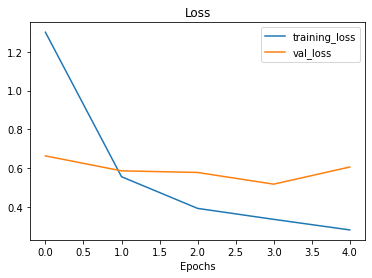

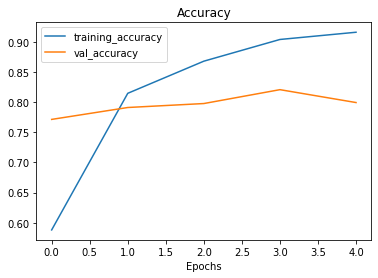

In [93]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

## Loading in checkpointed weights
Loading in checkpointed weights returns a model to specefic chekcpoint.

In [94]:
model_2.load_weights(checkpoint_path)

In [95]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 14s 171ms/step - loss: 0.5107 - accuracy: 0.8312


In [96]:
# If the results from our native model and the loaded weights are the same, this should output True
results_10_percent_data_aug == loaded_weights_model_results

False

If the above cell doesn't output True, it's because the numbers are close but not the exact same (due to how computers store numbers with degrees of precision).

However, they should be very close..

In [97]:
import numpy as np
# Check to see if loaded model results are very close to native model results (should output True)
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [98]:
# Check the difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[-5.96046448e-08  0.00000000e+00]


## Model 3: Fine-tuning an existing model on 10% of the data

This means all of the layers in the base model (EfficientNetB0) were frozen during training.

For our next experiment we're going to switch to fine-tuning transfer learning. This means we'll be using the same base model except we'll be unfreezing some of its layers (ones closest to the top) and running the model for a few more epochs.

The idea with fine-tuning is to start customizing the pre-trained model more to our own data.

🔑 Note: Fine-tuning usually works best after training a feature extraction model for a few epochs and with large amounts of data. For more on this, check out Keras' guide on Transfer learning & fine-tuning.

We've verified our loaded model's performance, let's check out its layers.



In [99]:
# Layers in loaded model
model_2.layers

In [100]:
# Are these layers trainable?
for layer in model_2.layers:
  print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f8e28aacdd0> True
<tensorflow.python.keras.engine.sequential.Sequential object at 0x7f8e97a9e150> True
<tensorflow.python.keras.engine.functional.Functional object at 0x7f8e3d09e990> False
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f8e3a6a2fd0> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f8e39e68d10> True


In [101]:
# What layers are in our base_model (EfficentNetB0) and are they trainable?
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_6 False
1 rescaling_5 False
2 normalization_5 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [102]:
# How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [103]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (We have to recompile our models everytime we make a change.)
model_2.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics = ['accuracy'])

In [104]:
# Check which layers are tunable (trainable)
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_6 False
1 rescaling_5 False
2 normalization_5 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [105]:
# Now we have unforzen some of the layers close to the top, how many trainables variables are there
print(len(model_2.trainable_variables))

12


In [106]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epoch + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs = fine_tune_epochs,
                                               validation_data = test_data,
                                               validation_steps = int(0.25 * len(test_data)),
                                               initial_epoch = history_10_percent_data_aug.epoch[-1], # start training from previous last epoch
                                               callbacks = [create_tensorboard_callback(dir_name = 'transfer_learning',
                                                                                        experiment_name = "10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20210815-131505
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 24s 701ms/step - loss: 0.1549 - accuracy: 0.9240 - val_loss: 0.1487 - val_accuracy: 0.8109
Epoch 6/10
24/24 [==============================] - 13s 548ms/step - loss: 0.0841 - accuracy: 0.9467 - val_loss: 0.1329 - val_accuracy: 0.8125
Epoch 7/10
24/24 [==============================] - 13s 550ms/step - loss: 0.0690 - accuracy: 0.9560 - val_loss: 0.1219 - val_accuracy: 0.8076
Epoch 8/10
24/24 [==============================] - 12s 510ms/step - loss: 0.0626 - accuracy: 0.9560 - val_loss: 0.1156 - val_accuracy: 0.8240
Epoch 9/10
24/24 [==============================] - 12s 489ms/step - loss: 0.0568 - accuracy: 0.9640 - val_loss: 0.1155 - val_accuracy: 0.8158
Epoch 10/10
24/24 [==============================] - 13s 523ms/step - loss: 0.0531 - accuracy: 0.9653 - val_loss: 0.1200 - val_accuracy: 0.8043


In [107]:
# Evaluate the fine-tuned model(model_3 which is model_2 which is fine tuned for another 5 epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 14s 170ms/step - loss: 0.1074 - accuracy: 0.8432


In [108]:
# Model_2 without fine-tuning
results_10_percent_data_aug

[0.5107077360153198, 0.8312000036239624]

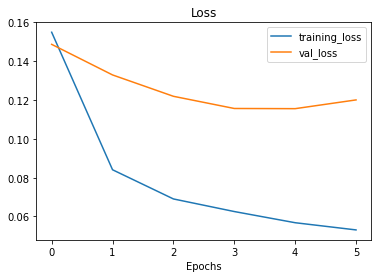

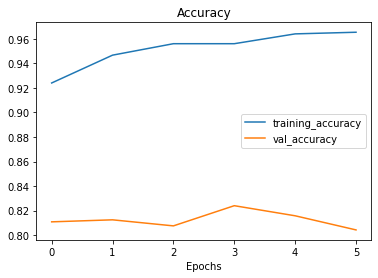

In [109]:
# Check out the loss curves of our fine-tuned model
plot_loss_curves(history_fine_10_percent_data_aug)

Remember, the results from evaluating the model might be slightly different to the outputs from training since during training we only evaluate on 25% of the test data.

Alright, we need a way to evaluate our model's performance before and after fine-tuning. How about we write a function to compare the before and after?

In [124]:
def compare_historys(original_history, new_history, initial_epochs = 5):
  """
  Compares two TensorFlow History objects
  """
  # Get original history measurements
  acc = original_history.history['accuracy']
  loss = original_history.history['loss']

  print(len(acc))

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Get total history measurements
  total_acc = acc + new_history.history['accuracy']
  total_loss = loss + new_history.history['loss']

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  print(len(total_acc))
  print(total_acc)

  # Make plots for accuracy
  plt.figure(figsize=(10,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc, label='Training Accuracy')
  plt.plot(total_val_acc, label='Validation Accuracy')
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label = 'Start Fine Tuning')
  plt.legend(loc = "lower right")
  plt.title("Training and Validation Accuracy")

  # Make plots for loss
  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label='Training Loss')
  plt.plot(total_val_loss, label='Validation Loss')
  plt.plot([initial_epochs-1, initial_epochs-1],
  plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

5
11
[0.5879999995231628, 0.8146666884422302, 0.8679999709129333, 0.9039999842643738, 0.9160000085830688, 0.9240000247955322, 0.9466666579246521, 0.9559999704360962, 0.9559999704360962, 0.9639999866485596, 0.9653333425521851]


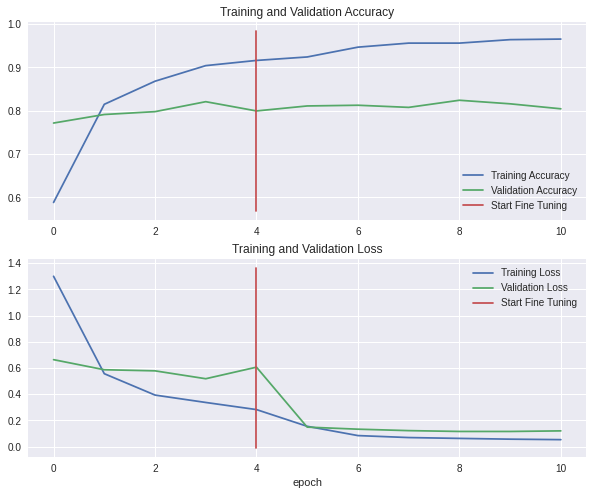

In [127]:

compare_historys(history_10_percent_data_aug, history_fine_10_percent_data_aug)

Alright, alright, seems like the curves are heading in the right direction after fine-tuning. But remember, it should be noted that fine-tuning usually works best with larger amounts of data.

##Model 4: Fine-tuning an existing model all of the data

Enough talk about how fine-tuning a model usually works with more data, let's try it out.

We'll start by downloading the full version of our 10 food classes dataset.

In [130]:
# Download and unzip 10 classes of data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 
unzip_data("10_food_classes_all_data.zip")

# Setup data directories
train_dir_all_data = "10_food_classes_all_data/train/"
test_dir_all_data = "10_food_classes_all_data/test/"

--2021-08-15 13:38:26--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 74.125.204.128, 64.233.187.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip.1’

10_food_classes_all 100%[===================>] 495.13M   173MB/s    in 2.9s    

2021-08-15 13:38:29 (173 MB/s) - ‘10_food_classes_all_data.zip.1’ saved [519183241/519183241]



In [131]:
# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 

In [132]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode = 'categorical',
                                                                                 image_size = IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = 'categorical',
                                                                image_size = IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Oh this is looking good. We've got 10x more images in of the training classes to work with.

The test dataset is the same we've been using for our previous experiments.

As it is now, our model_2 has been fine-tuned on 10 percent of the data, so to begin fine-tuning on all of the data and keep our experiments consistent, we need to revert it back to the weights we checkpointed after 5 epochs of feature-extraction.

To demonstrate this, we'll first evaluate the current model_2.

In [133]:
# Evaluate model (this is the fine-tuned 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 14s 174ms/step - loss: 0.1074 - accuracy: 0.8432


[0.10740189254283905, 0.8432000279426575]

In [134]:
results_fine_tune_10_percent

[0.10740190744400024, 0.8432000279426575]

Now we'll revert the model back to the saved weights.



In [135]:
# Load model from checkpoint, that way we can fine-tune from the same stage the 10 percent data model was fine-tuned from
model_2.load_weights(checkpoint_path) # revert model back to saved weights

In [136]:
# Let's evaluate model_2 now
model_2.evaluate(test_data)

79/79 [==============================] - 14s 172ms/step - loss: 0.3888 - accuracy: 0.8312


[0.38876843452453613, 0.8312000036239624]

In [137]:
# Check to see if our model_2 has been reverted to feature extraction results
results_10_percent_data_aug

[0.5107077360153198, 0.8312000036239624]

Alright, the previous steps might seem quite confusing but all we've done is:

Trained a feature extraction transfer learning model for 5 epochs on 10% of the data (with all base model layers frozen) and saved the model's weights using ModelCheckpoint.
Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen.
Saved the results and training logs each time.
Reloaded the model from 1 to do the same steps as 2 but with all of the data.
The same steps as 2?

Yeah, we're going to fine-tune the last 10 layers of the base model with the full dataset for another 5 epochs but first let's remind ourselves which layers are trainable.

In [138]:
# Check which layers are tuneable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_layer True
4 output_layer True


In [139]:
# Check which layers are tuneable in the base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_6 False
1 rescaling_5 False
2 normalization_5 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [140]:
# Compile the model
model_2.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics = ['accuracy'])

In [147]:
# Fit the model with full data
fine_tune_epochs = initial_epoch + 5
history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           callbacks=[create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20210815-140009
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


235/235 [==============================] - 74s 287ms/step - loss: 0.6823 - accuracy: 0.7837 - val_loss: 0.3457 - val_accuracy: 0.8865
Epoch 6/10
235/235 [==============================] - 85s 359ms/step - loss: 0.5484 - accuracy: 0.8229 - val_loss: 0.3208 - val_accuracy: 0.9046
Epoch 7/10
235/235 [==============================] - 77s 326ms/step - loss: 0.4812 - accuracy: 0.8452 - val_loss: 0.3143 - val_accuracy: 0.9062
Epoch 8/10
235/235 [==============================] - 70s 293ms/step - loss: 0.4515 - accuracy: 0.8532 - val_loss: 0.2893 - val_accuracy: 0.9095
Epoch 9/10
235/235 [==============================] - 71s 298ms/step - loss: 0.3935 - accuracy: 0.8705 - val_loss: 0.2942 - val_accuracy: 0.9128
Epoch 10/10
235/235 [==============================] - 68s 289ms/step - loss: 0.3595 - accuracy: 0.8872 - val_loss: 0.2893 - val_accuracy: 0.9128


In [148]:
# Evaluate our new model
model_2.evaluate(test_data)

79/79 [==============================] - 14s 171ms/step - loss: 0.3031 - accuracy: 0.9048


[0.30310767889022827, 0.9047999978065491]

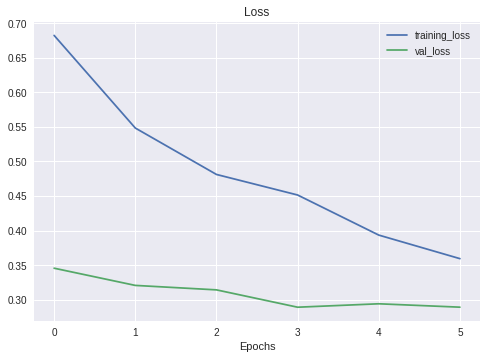

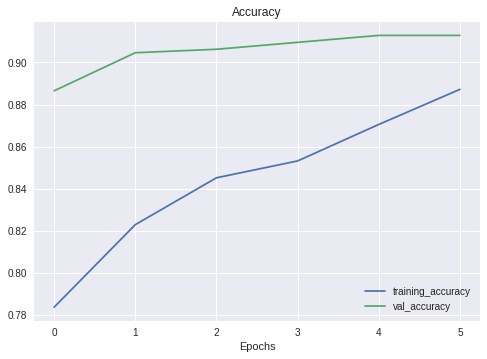

In [149]:
# Plotting loss curves
plot_loss_curves(history_fine_10_classes_full)

5
11
[0.5879999995231628, 0.8146666884422302, 0.8679999709129333, 0.9039999842643738, 0.9160000085830688, 0.7837333083152771, 0.8229333162307739, 0.8452000021934509, 0.8532000184059143, 0.8705333471298218, 0.8871999979019165]


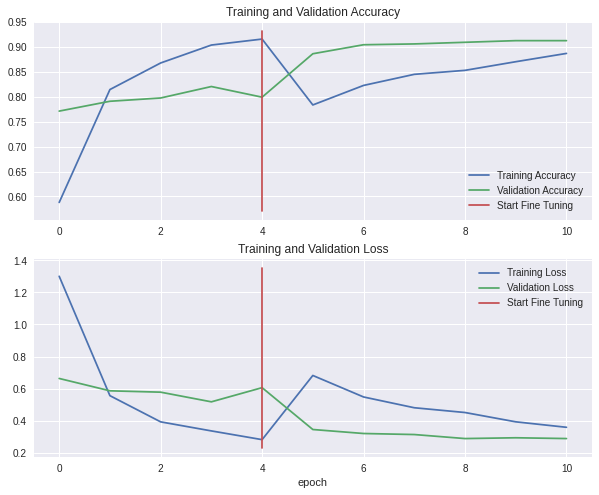

In [150]:
# Compare historys
compare_historys(original_history = history_10_percent_data_aug,
                 new_history = history_fine_10_classes_full)

## Viewing our experiment data on TensorBoard
## View tensorboard logs of transfer learning modelling experiments (should be 4 models)

In [153]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer learning experiments" \
  --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning" \
  --one_shot # exits the uploader when upload has finished

2021-08-15 14:10:51.533678: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3

In [154]:
# View previous experiments
!tensorboard dev list

2021-08-15 14:11:55.193448: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
https://tensorboard.dev/experiment/r2wGvSKFQ92c4fXO9Wk0UA/
	Name                 Transfer learning experiments
	Description          A series of different transfer learning experiments with varying amounts of data and fine-tuning
	Id                   r2wGvSKFQ92c4fXO9Wk0UA
	Created              2021-08-15 14:11:15 (47 seconds ago)
	Updated              2021-08-15 14:11:30 (32 seconds ago)
	Runs                 18
	Tags                 5
	Scalars              288
	Tensor bytes         0
	Binary object bytes  7602289
https://tensorboard.dev/experiment/CaKSpkLIQr6W7t2ElSAfbw/
	Name                 EfficentNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architecture using 10% of the training data
	Id                   CaKSpkLIQr6W7t2ElSAfbw
	Created              2021-08-01 12:22:11
	Updated     